concatenación de los vectores de ruido e imágen (después de ser comprimido)

PROBAR CON IB_FAITHFULL

In [1]:
import io, re
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df=pd.read_parquet("../datos/ib_faithful_1.21.1_32.parquet")
print(device)

img_size=32

cuda


In [2]:
def mostrar_resultados(resultados):
    """
    Muestra una lista de imágenes generadas con sus etiquetas.
    """
    plt.figure(figsize=(8, 2))
    for i, (img, label) in enumerate(resultados):
        plt.subplot(1, len(resultados), i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(label)
    plt.tight_layout()
    plt.show()

def generar_imagenes(decoder, text_embedding, prompt: str, n_samples=4, latent_dim=128, device="cuda"):
    # Establecer los modelos en modo evaluación
    decoder.eval()
    text_embedding.eval()

    with torch.no_grad():
        # 1. Embedding condicional del texto
        cond_emb = text_embedding([prompt] * n_samples).to(device)

        # 2. Ruido aleatorio
        z = torch.randn(n_samples, latent_dim, device=device)

        # 3. Generar imágenes usando el decoder
        fake_imgs = decoder(z, cond_emb).detach().cpu()

        # 4. Desnormalizar de [-1, 1] a [0, 1]
        fake_imgs = (fake_imgs * 0.5 + 0.5).clamp(0, 1)

        # 5. Convertir a PIL y devolver
        results = []
        for i in range(n_samples):
            img_pil = TF.to_pil_image(fake_imgs[i])
            results.append((img_pil, prompt))
    
    return results


# Dataset único (con augment)
class MinecraftDataset(Dataset):
    def __init__(self, rows: List[dict], image_size=img_size, augment=False):
        self.rows = rows
        self.image_size = image_size
        self.augment = augment
        self.transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(),
            T.Normalize([0.5]*3, [0.5]*3)])

    def __len__(self):
        return len(self.rows)

    def __getitem__(self, idx):
        r = self.rows[idx]
        img = Image.open(io.BytesIO(r["image"]["bytes"])).convert("RGB")
        img_t = self.transform(img)
        if self.augment and torch.rand(1).item() > 0.5:
            img_t = torch.flip(img_t, dims=[2])
        label = r["label"]
        return img_t, label


# Embedding textual (por palabra)
class TextEmbedding(nn.Module):
    def __init__(self, vocab, embed_dim=100):
        super().__init__()
        self.vocab = vocab
        self.stoi = {w: i for i, w in enumerate(vocab)}
        self.embedding = nn.Embedding(len(vocab), embed_dim)

    @staticmethod
    def build_vocab(labels):
        words = set()
        for lbl in labels:
            for w in re.findall(r"\w+", lbl.lower()):
                words.add(w)
        return sorted(words)

    def forward(self, label_texts: List[str]):
        device = next(self.embedding.parameters()).device
        vectors = []
        for text in label_texts:
            tokens = [w for w in re.findall(r"\w+", text.lower()) if w in self.stoi]
            if not tokens:
                tokens = ["unknown"]
            idxs = torch.tensor([self.stoi[w] for w in tokens], device=device)
            emb = self.embedding(idxs).mean(dim=0)
            vectors.append(emb)
        return torch.stack(vectors)

#### Crear modelo

In [3]:
# ==========================================
# Encoder
# Entrada: Imagen + Texto
# Salida: Media y Log-Varianza
# ==========================================
class Encoder(nn.Module):
    def __init__(self, embed_dim=100, latent_dim=128, ndf=32, img_channels=3):
        super(Encoder, self).__init__()
        
        # 32x32 -> 4x4
        self.conv = nn.Sequential(
            # 32x32 -> 16x16
            nn.Conv2d(img_channels, ndf, 4, 2, 1),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 16x16 -> 8x8
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 8x8 -> 4x4
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Dimensión aplanada
        self.flat_dim = (ndf * 4) * 4 * 4
        
        # Capas lineales Imagen aplanada + Embedding de texto concatenados
        self.fc_mu = nn.Linear(self.flat_dim + embed_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flat_dim + embed_dim, latent_dim)

    def forward(self, img, cond_emb):
        x = self.conv(img)
        x = x.flatten(start_dim=1) 
        
        # Concatenar con el texto
        x = torch.cat([x, cond_emb], dim=1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

# ==========================================
#  DECODER 
# Entrada: Vector Latente + Texto
# Salida: Imagen Reconstruida
# ==========================================
class Decoder(nn.Module):
    def __init__(self, embed_dim=100, latent_dim=128, ngf=32, out_channels=3):
        super(Decoder, self).__init__()
        self.ngf = ngf
        
        # Proyección lineal 
        # Entrada: z + texto
        self.fc_input = nn.Linear(latent_dim + embed_dim, (ngf * 4) * 4 * 4)
        
        # Red Convolucional Transpuesta 
        # 4x4 -> 32x32
        self.deconv = nn.Sequential(
            # 4x4 -> 8x8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            # 8x8 -> 16x16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # 16x16 -> 32x32
            nn.ConvTranspose2d(ngf, out_channels, 4, 2, 1),
            nn.Tanh() # [-1, 1]
        )

    def forward(self, z, cond_emb):
        # Normalizar
        z = z / (z.norm(dim=1, keepdim=True) + 1e-8)
        cond_emb = cond_emb / (cond_emb.norm(dim=1, keepdim=True) + 1e-8)
        # Concatenar latente y texto
        x = torch.cat([z, cond_emb], dim=1)
        
        # Proyectar y redimensionar 
        x = self.fc_input(x)
        x = x.view(-1, self.ngf * 4, 4, 4)
        
        return self.deconv(x)

# ==========================================
# 3. CVAE
# ==========================================
class CVAE_Wrapper(nn.Module):
    def __init__(self, encoder, decoder):
        super(CVAE_Wrapper, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, img, cond_emb):
        mu, logvar = self.encoder(img, cond_emb)
        z = self.reparameterize(mu, logvar)
        recon_img = self.decoder(z, cond_emb)
        
        return recon_img, mu, logvar

In [4]:
# === CONFIGURACIÓN ===
latent_dim = 128
embed_dim = 100      # dimensión del embedding textual
ndf = 32 
ngf = 32 

batch_size = 32
lr = 1e-4
beta_kl = 0.1 # Peso de la divergencia KL

In [5]:
# Construir vocabulario
all_labels = df["label"].tolist()
cleaned_labels = [re.sub(r"\d+", "", lbl).strip() for lbl in all_labels]
all_labels = list(set(cleaned_labels))

vocab = TextEmbedding.build_vocab(all_labels)

print(f" Vocabulario generado con {len(vocab)} palabras únicas:")
# print(vocab)

# Dataset y DataLoader
dataset = MinecraftDataset(df.to_dict("records"), image_size=img_size, augment=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


 Vocabulario generado con 604 palabras únicas:


#### Entrenamiento

In [6]:
# MODELOS
txt_emb = TextEmbedding(vocab, embed_dim=embed_dim).to(device)
E = Encoder(embed_dim=embed_dim, latent_dim=latent_dim, ndf=ndf).to(device)
D = Decoder(embed_dim=embed_dim, latent_dim=latent_dim, ngf=ngf).to(device)
cvae = CVAE_Wrapper(E, D).to(device)


In [7]:
optimizer = optim.Adam(list(E.parameters()) + list(D.parameters()) + list(txt_emb.parameters()), lr=lr)

def loss_function(recon_x, x, mu, logvar, beta=0.1):
    batch_size = x.size(0)
    
    # mse promedio por img
    MSE = F.mse_loss(recon_x, x, reduction='sum') / batch_size
    
    # KL promedio por img
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()
    
    # Pérdida total
    return MSE + (beta * KLD), MSE, KLD

Comenzando entrenamiento CVAE...
Época [0/4000] Loss Total: 572.3669 | Recon (MSE): 558.5014 | KL: 138.6553


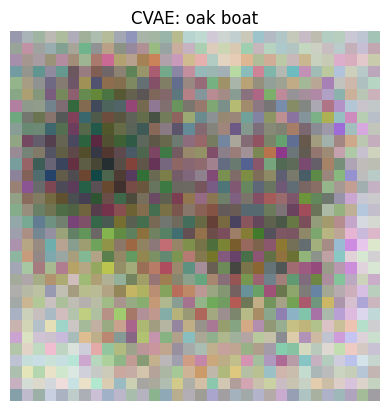

Época [100/4000] Loss Total: 202.5968 | Recon (MSE): 181.1954 | KL: 214.0141


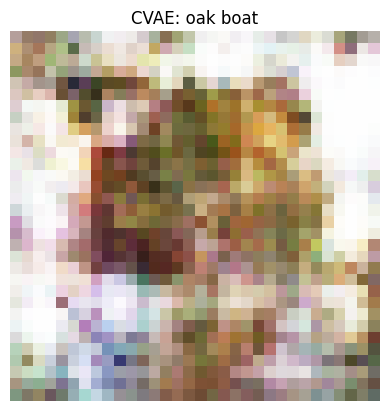

Época [200/4000] Loss Total: 93.6778 | Recon (MSE): 72.3678 | KL: 213.1000


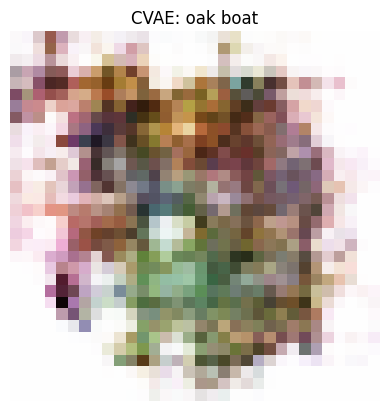

Época [300/4000] Loss Total: 62.6510 | Recon (MSE): 44.5605 | KL: 180.9053


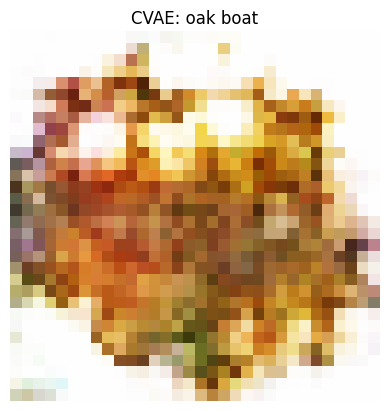

Época [400/4000] Loss Total: 52.6908 | Recon (MSE): 35.3234 | KL: 173.6741


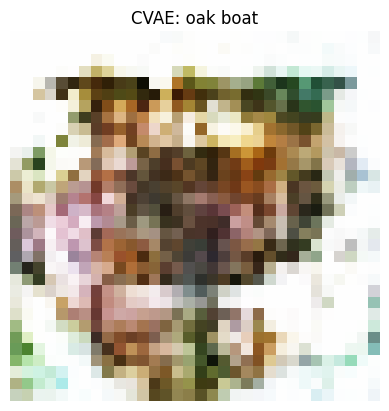

Época [500/4000] Loss Total: 55.4780 | Recon (MSE): 37.5952 | KL: 178.8277


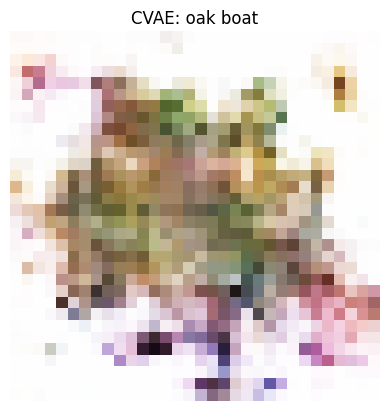

Época [600/4000] Loss Total: 59.6232 | Recon (MSE): 41.9045 | KL: 177.1874


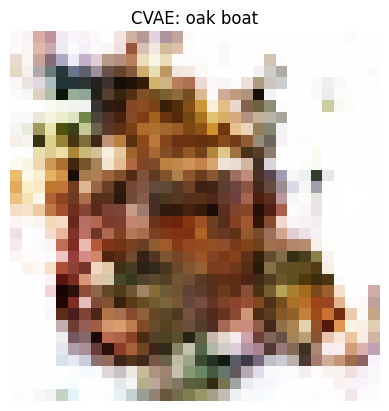

Época [700/4000] Loss Total: 44.9684 | Recon (MSE): 28.6116 | KL: 163.5680


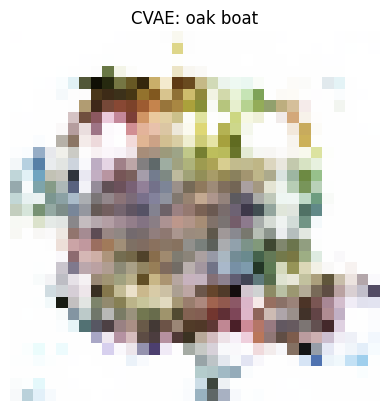

Época [800/4000] Loss Total: 68.3953 | Recon (MSE): 51.1915 | KL: 172.0384


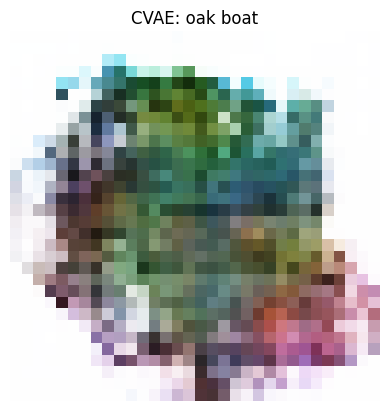

Época [900/4000] Loss Total: 58.3100 | Recon (MSE): 41.1317 | KL: 171.7834


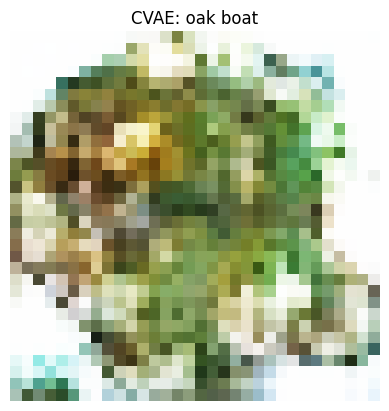

Época [1000/4000] Loss Total: 49.0164 | Recon (MSE): 32.6579 | KL: 163.5854


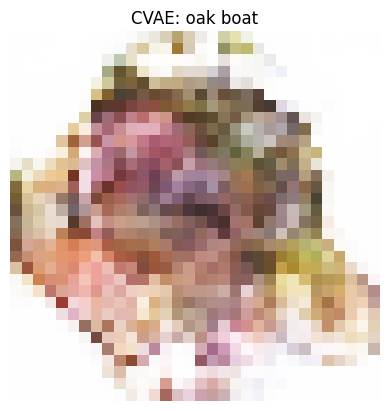

Época [1100/4000] Loss Total: 58.0696 | Recon (MSE): 40.7465 | KL: 173.2315


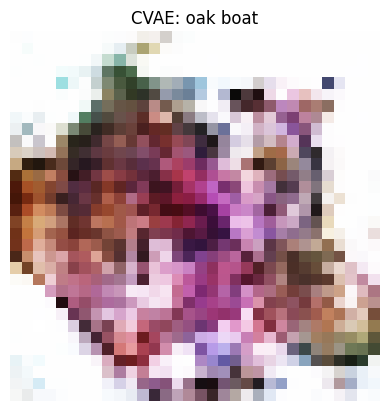

Época [1200/4000] Loss Total: 37.5330 | Recon (MSE): 22.1110 | KL: 154.2203


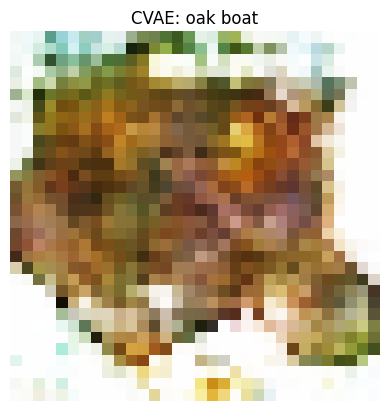

Época [1300/4000] Loss Total: 34.3076 | Recon (MSE): 23.9040 | KL: 104.0362


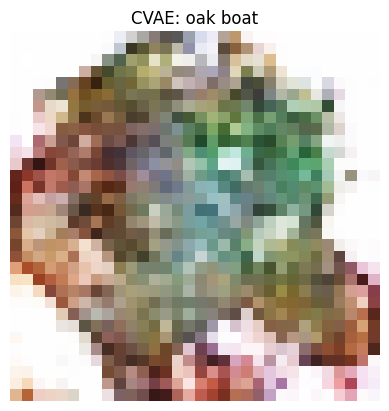

Época [1400/4000] Loss Total: 42.6390 | Recon (MSE): 28.3723 | KL: 142.6671


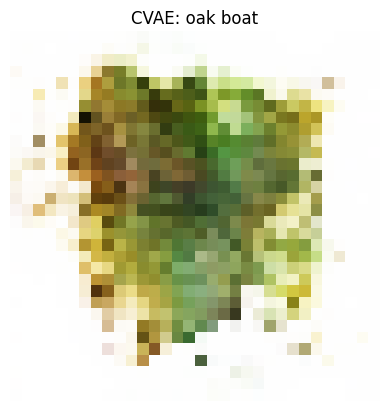

Época [1500/4000] Loss Total: 45.4612 | Recon (MSE): 30.9636 | KL: 144.9759


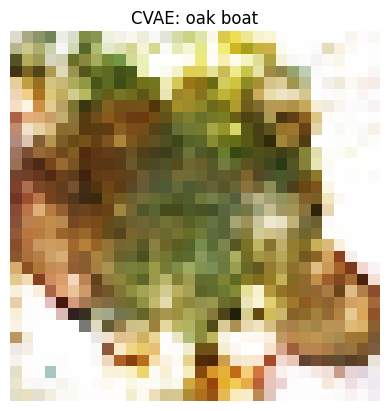

Época [1600/4000] Loss Total: 51.0370 | Recon (MSE): 35.2507 | KL: 157.8626


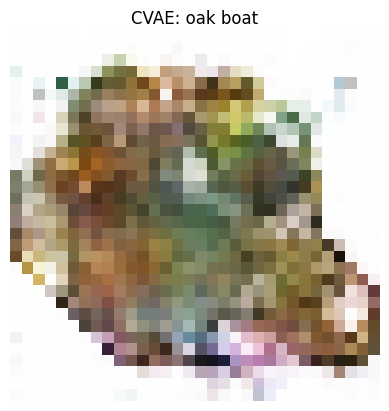

Época [1700/4000] Loss Total: 38.1828 | Recon (MSE): 24.7578 | KL: 134.2496


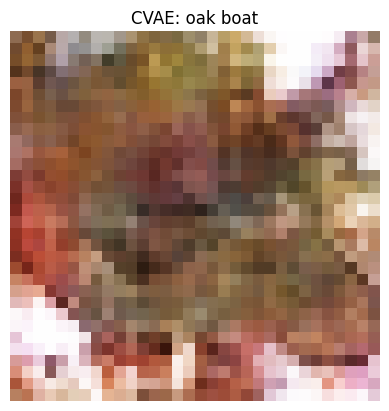

Época [1800/4000] Loss Total: 38.3030 | Recon (MSE): 25.3410 | KL: 129.6195


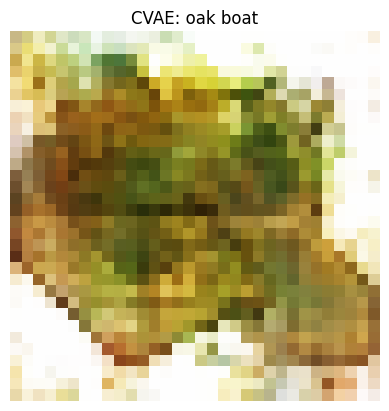

Época [1900/4000] Loss Total: 46.1947 | Recon (MSE): 32.7619 | KL: 134.3284


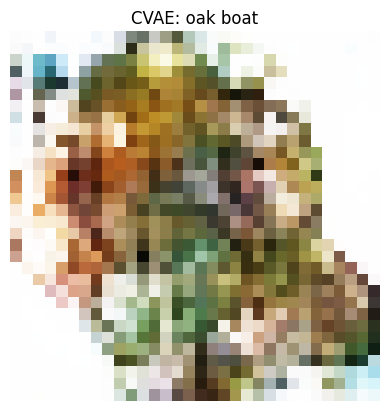

Época [2000/4000] Loss Total: 54.7400 | Recon (MSE): 39.1680 | KL: 155.7194


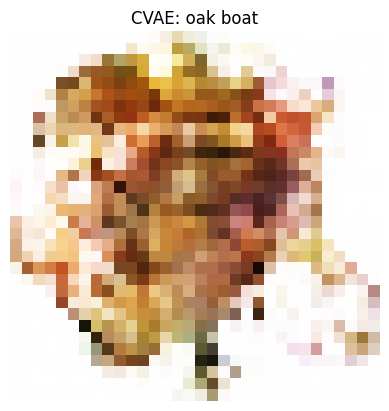

Época [2100/4000] Loss Total: 57.8330 | Recon (MSE): 42.8257 | KL: 150.0729


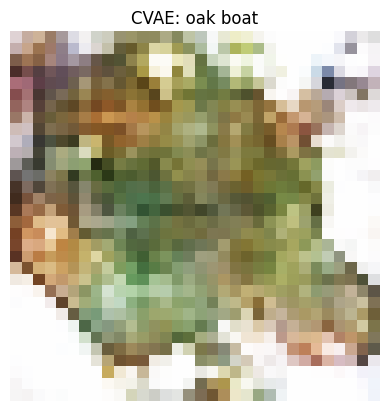

Época [2200/4000] Loss Total: 35.8305 | Recon (MSE): 23.6113 | KL: 122.1912


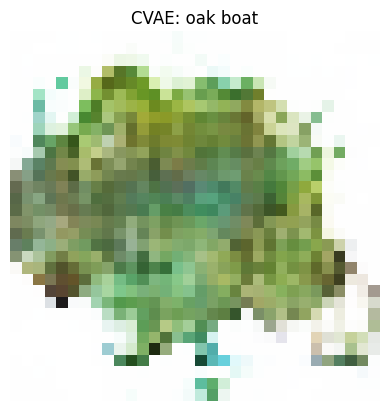

Época [2300/4000] Loss Total: 39.6503 | Recon (MSE): 25.6370 | KL: 140.1324


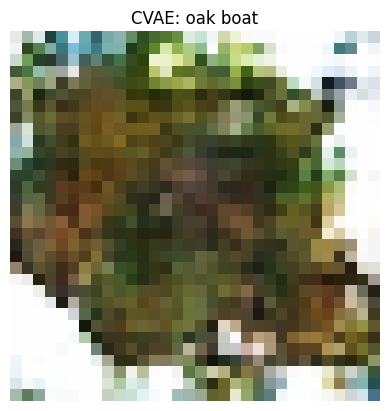

Época [2400/4000] Loss Total: 39.1912 | Recon (MSE): 24.7751 | KL: 144.1616


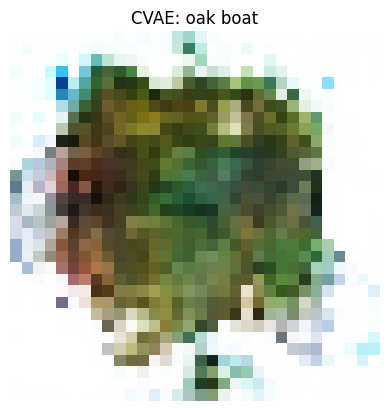

Época [2500/4000] Loss Total: 33.2923 | Recon (MSE): 22.3022 | KL: 109.9009


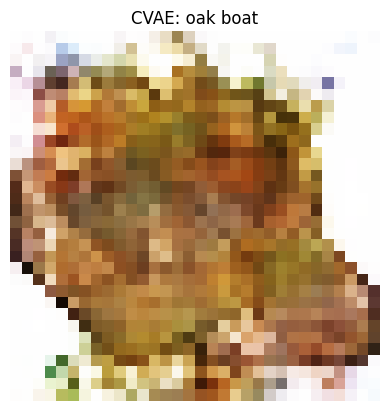

Época [2600/4000] Loss Total: 39.0868 | Recon (MSE): 25.3298 | KL: 137.5700


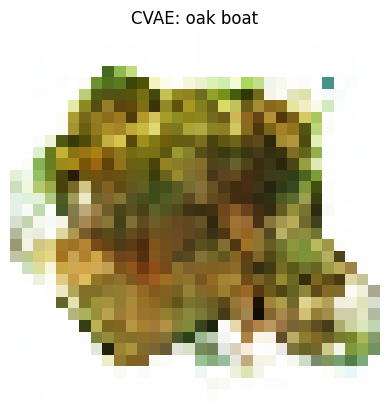

Época [2700/4000] Loss Total: 37.6239 | Recon (MSE): 23.4612 | KL: 141.6267


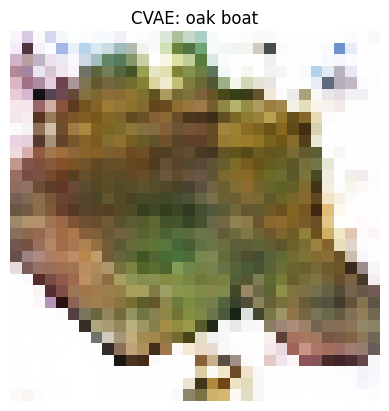

Época [2800/4000] Loss Total: 40.3144 | Recon (MSE): 28.8074 | KL: 115.0708


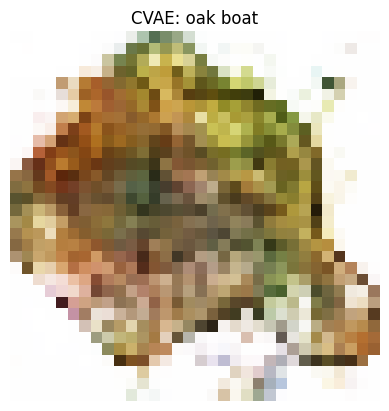

Época [2900/4000] Loss Total: 74.2334 | Recon (MSE): 58.7397 | KL: 154.9366


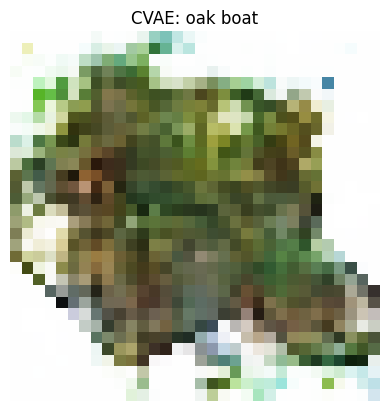

Época [3000/4000] Loss Total: 42.0471 | Recon (MSE): 27.7765 | KL: 142.7059


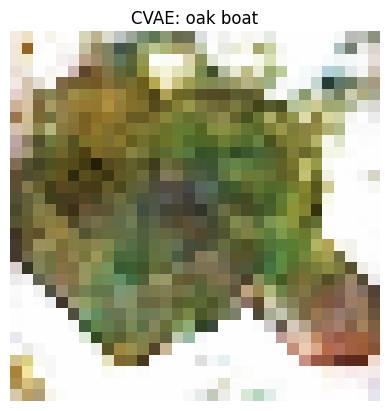

Época [3100/4000] Loss Total: 36.6442 | Recon (MSE): 23.1685 | KL: 134.7574


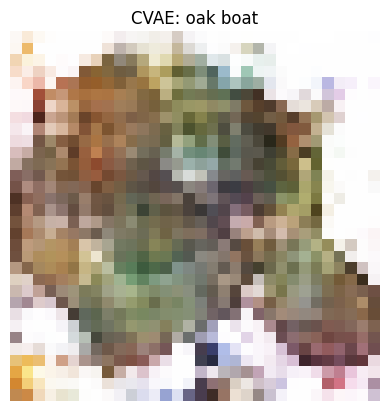

Época [3200/4000] Loss Total: 48.1481 | Recon (MSE): 36.0590 | KL: 120.8913


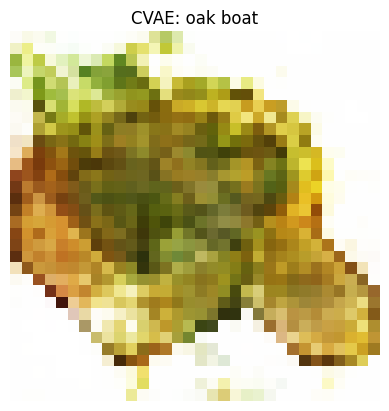

Época [3300/4000] Loss Total: 44.0596 | Recon (MSE): 29.2815 | KL: 147.7808


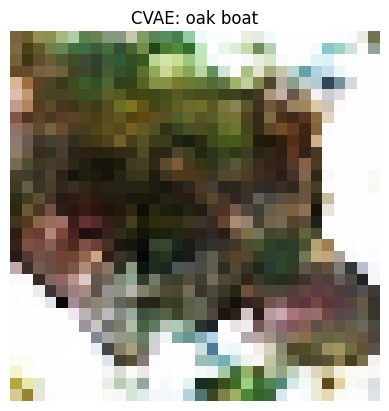

Época [3400/4000] Loss Total: 36.4619 | Recon (MSE): 23.4411 | KL: 130.2080


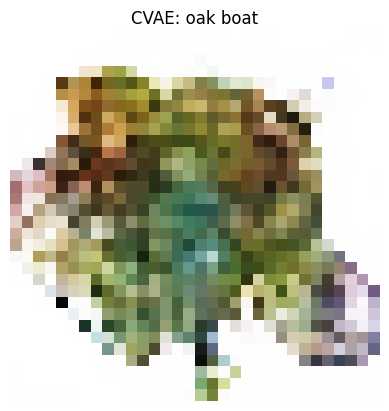

Época [3500/4000] Loss Total: 40.8576 | Recon (MSE): 27.5639 | KL: 132.9370


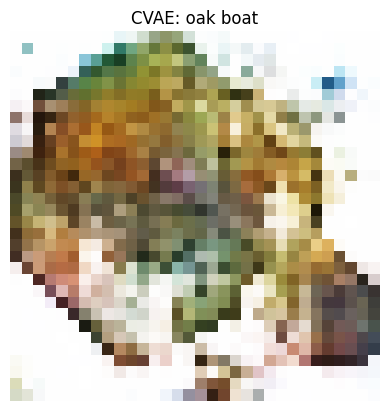

Época [3600/4000] Loss Total: 27.4051 | Recon (MSE): 16.7124 | KL: 106.9266


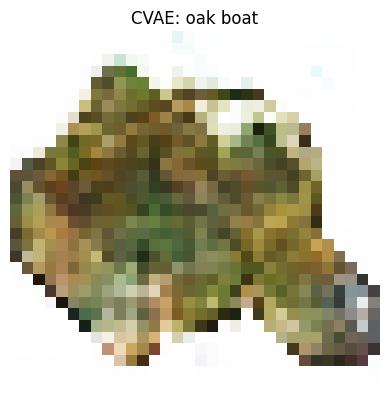

Época [3700/4000] Loss Total: 31.9224 | Recon (MSE): 22.8874 | KL: 90.3500


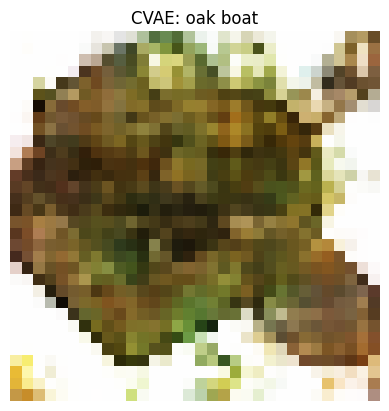

Época [3800/4000] Loss Total: 100.4550 | Recon (MSE): 87.8297 | KL: 126.2533


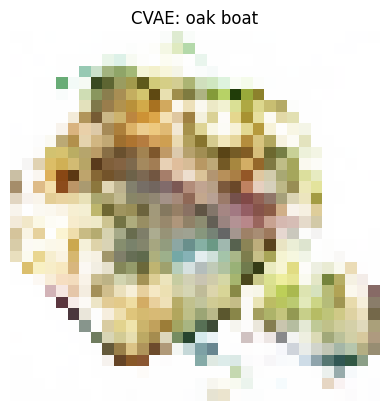

Época [3900/4000] Loss Total: 49.1510 | Recon (MSE): 37.2784 | KL: 118.7258


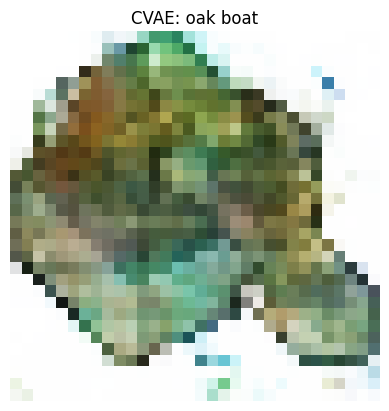

In [9]:
num_epochs = 4000

print("Comenzando entrenamiento CVAE...")
for epoch in range(num_epochs):
    for real_imgs, labels in dataloader:
        real_imgs = real_imgs.to(device)
        cond_emb = txt_emb(labels).to(device)
        recon_imgs, mu, logvar = cvae(real_imgs, cond_emb)
        
        # Calcular pérdida
        loss, mse, kld = loss_function(recon_imgs, real_imgs, mu, logvar, beta=beta_kl)
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # =========================================================
    # LOGGING
    # =========================================================
    if epoch % 100 == 0: 
        print(f"Época [{epoch}/{num_epochs}] "
              f"Loss Total: { loss.item():.4f} | Recon (MSE): {mse.item():.4f} | KL: {kld.item():.4f}")

        # Generar una imagen de ejemplo condicional
        cvae.eval() 
        with torch.no_grad():
            test_prompt = "oak boat" 
            test_emb = txt_emb([test_prompt]).to(device)
            
            z = torch.randn(1, latent_dim, device=device)
            fake_test = cvae.decoder(z, test_emb).detach().cpu()

            # Visualización
            img_vis = (fake_test[0] * 0.5 + 0.5).clamp(0, 1)
            plt.imshow(TF.to_pil_image(img_vis))
            plt.title(f"CVAE: {test_prompt}")
            plt.axis("off")
            plt.show()
        cvae.train() # Volver a modo entrenamiento

#### resultados

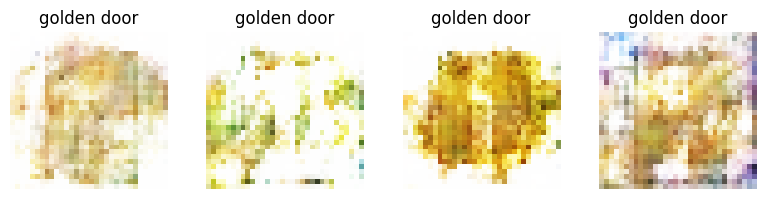

In [16]:
# Generar y mostrar
prompt = "golden door"
resultados = generar_imagenes(D, txt_emb, prompt)
mostrar_resultados(resultados)


#### Guardar modelos

In [11]:
# GUARDAR MODELOS
import os
import torch

version = "v4" 
save_dir = f"./modelos/{version}"

os.makedirs(save_dir, exist_ok=True)

# === Guardar modelos ===
torch.save(E.state_dict(), os.path.join(save_dir, "encoder.pth"))
torch.save(D.state_dict(), os.path.join(save_dir, "decoder.pth"))
torch.save(cvae.state_dict(), os.path.join(save_dir, "cvae.pth"))
torch.save(txt_emb.state_dict(), os.path.join(save_dir, "text_embedding.pth"))

print(f" Modelos guardados en: {save_dir}")


 Modelos guardados en: ./modelos/v4


#### Importar modelos

In [ ]:
import torch
import os

# === Configuración ===
device = "cuda" if torch.cuda.is_available() else "cpu"
version = "v3"  
embed_dim = 100 
save_dir = f"./modelos/{version}"

# Construir vocabulario
all_labels = df["label"].tolist()
cleaned_labels = [re.sub(r"\d+", "", lbl).strip() for lbl in all_labels]
all_labels = list(set(cleaned_labels))
vocab = TextEmbedding.build_vocab(all_labels)

# === Inicializar modelos ===
txt_emb = TextEmbedding(vocab, embed_dim=embed_dim).to(device)
D = Decoder(embed_dim=embed_dim, latent_dim=latent_dim, ngf=ngf).to(device)

# === Cargar pesos ===
D.load_state_dict(torch.load(os.path.join(save_dir, "decoder.pth"), map_location=device))
txt_emb.load_state_dict(torch.load(os.path.join(save_dir, "text_embedding.pth"), map_location=device))

# === Pasar a modo evaluación ===
D.eval()
txt_emb.eval()

print(" Modelos cargados correctamente desde", save_dir)


 Modelos cargados correctamente desde ./modelos/v3


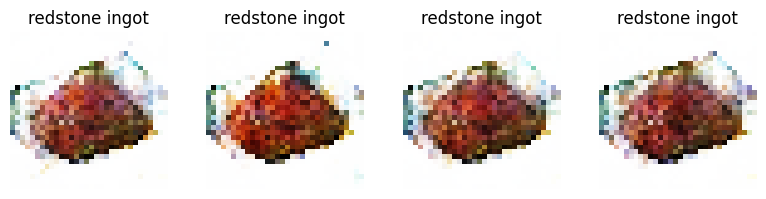

In [ ]:
# Generar y mostrar
prompt = "redstone ingot"
resultados = generar_imagenes(D, txt_emb, prompt)
mostrar_resultados(resultados)